In [2]:
import os
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pandas as pd
import pickle
from sklearn.utils import resample
import matplotlib as mpl


In [ ]:
# Define directory paths
directory_path = './rep1/'
Genome_path = 'Genome_information/'

# Define groups
group1, group2 = 'p1', 'p2'

# Load HDF5 files
p1 = h5py.File(f"{directory_path}Translatome_rep1.h5", 'r')
p2 = h5py.File(f"{directory_path}TOM_interactome_rep1.h5", 'r')

# Function to calculate total counts and save them to a file
def calculate_total_counts(group, file_handle):
    output_file = f"{directory_path}{group}_count_reads"
    
    # Check if the file exists and load the total counts directly
    if os.path.exists(output_file):
        with open(output_file, 'r') as inFile:
            total_counts = int(float(inFile.readline().strip()))
            print(f"Loaded total reads for {group}: {total_counts}")
            return total_counts
    
    # Calculate total counts if the file doesn't exist
    df = pd.read_csv(f"{Genome_path}human gene localization.csv")
    total_counts = 0
    
    for gene in df['gene']:
        if gene in p1 and gene in p2:
            total_counts += sum(file_handle[gene][1])

    # total_counts = sum(sum(file_handle[gene][1]) for gene in file_handle.keys())
    
    with open(output_file, 'w') as outFile:
        outFile.write(str(total_counts))
    
    print(f"Calculated and saved total reads for {group}: {total_counts}")
    return total_counts

# Compute total reads
p1_Total_Reads = calculate_total_counts('p1', p1)
p2_Total_Reads = calculate_total_counts('p2', p2)

Loaded total reads for p1: 3055778
Loaded total reads for p2: 1293252


In [15]:
# Function to convert nucleotide-level reads to codon-level reads
def nt_to_codon(group, gene):
    p = p1 if group == group1 else p2
    codon_dict = defaultdict(int)

    for index, nt_position in enumerate(p[gene][0].tolist()):
        codon_idx = math.ceil(nt_position / 3)
        codon_dict[codon_idx] += p[gene][1][index]

    return codon_dict

# Function to process gene trace
def gene_trace(group, gene):
    Reads, p = (p1_Total_Reads, p1) if group == group1 else (p2_Total_Reads, p2)
    codon_length = int(p[gene].attrs['cds_length']) // 3
    Dict_c = nt_to_codon(group, gene)
    
    window, flank = 15, 7  # Adjusted flank calculation for clarity

    # Normalize codon reads
    Dict_c = {k: 0.05 + (Dict_c.get(k, 0) / Reads * 1e6) for k in range(1, codon_length + 1)}

    # Apply smoothing
    Dict_s = {}
    for i in range(1, codon_length + 1):
        start, end = max(1, i - flank), min(codon_length, i + flank)
        Dict_s[i] = sum(Dict_c[j] for j in range(start, end + 1)) / (end - start + 1)

    return sorted(Dict_s.items())

# Function to compute gene enrichment
def gene_enrichment(gene):
    List1, List2 = gene_trace('p1', gene), gene_trace('p2', gene)
    x1, y1 = zip(*List1)
    x2, y2 = zip(*List2)

    y3 = [(y2[i] / y1[i]) if y1[i] != 0 and y2[i] != 0 else np.nan for i in range(len(y1))]
    y4 = [0] * len(x1)

    return x1, y1, y2, y3, y4



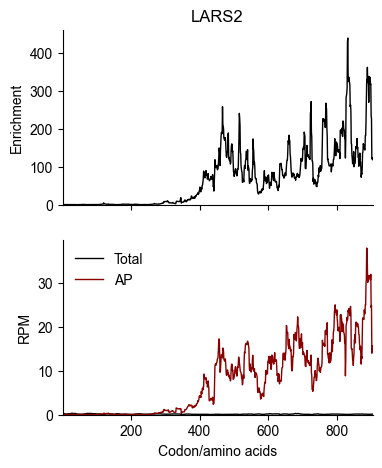

In [16]:
# Function to plot gene enrichment
def plot_gene_enrichment(gene):
    x1, y1, y2, y3, y4 = gene_enrichment(gene)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(4, 5), sharex=True)

    # Plot RPM values
    ax2.plot(x1, y1, color='black', linewidth=1)
    ax2.plot(x1, y2, color='darkred', linewidth=1)
    ax2.set_ylabel('RPM')
    ax2.legend(['Total', 'AP'], loc='upper left', prop={'size': 10})
    ax2.set_ylim(0,)

    # Plot enrichment values
    ax1.plot(x1, y3, color='black', linewidth=1)
    ax1.set_ylabel('Enrichment')
    ax1.set_ylim(0, )

    # Adjust aesthetics
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    legend=ax2.legend(['Total', 'AP'], loc='upper left',prop={'size':10})
    legend.get_frame().set_linewidth(0.0)
    ax1.set_xlim(1, len(x1))
    ax1.set_title(gene)
    ax2.set_xlabel('Codon/amino acids')

    plt.show()

plot_gene_enrichment('LARS2')


In [17]:
# Load gene localization data
def load_gene_localization(file_path):
    df = pd.read_csv(file_path)
    return df.set_index('gene')['localization'].to_dict()

gene_localization = load_gene_localization(f"{Genome_path}human gene localization.csv")

# Calculate RPKM
def calculate_rpkm(count, total_reads, length):
    if total_reads == 0 or length == 0:
        return np.nan
    return (count / total_reads / length) * 1e9

# Process gene data
def process_gene_data(gene):
    if gene not in p1 or gene not in p2:
        return None

    p1_count = sum(p1[gene][1])
    p2_count = sum(p2[gene][1])
    length = int(p1[gene].attrs['cds_length'])
    codon_length = length // 3

    p1_RPKM = calculate_rpkm(p1_count, p1_Total_Reads, length)
    p2_RPKM = calculate_rpkm(p2_count, p2_Total_Reads, length)

    ratio = p2_RPKM / p1_RPKM if p1_RPKM > 0 else np.nan
    log2_ratio = np.log2(ratio) if ratio > 0 else np.nan

    p1_norm = p1_count / codon_length if codon_length > 0 else np.nan
    p2_norm = p2_count / codon_length if codon_length > 0 else np.nan

    return {
        'localization': gene_localization.get(gene, 'Unknown'),
        'Length': codon_length,
        f'{group1}_count': p1_count,
        f'{group2}_count': p2_count,
        f'{group1}_RPKM': p1_RPKM,
        f'{group2}_RPKM': p2_RPKM,
        'ratio': ratio,
        'Log2_ratio': log2_ratio,
        f'{group1}_norm': p1_norm,
        f'{group2}_norm': p2_norm
    }

# Generate gene enrichment dataframe
def generate_gene_enrichment_dataframe():
    gene_loc = {gene: data for gene in gene_localization if (data := process_gene_data(gene))}
    gene_loc_df = pd.DataFrame.from_dict(gene_loc, orient='index')
    gene_loc_df.index.name = 'gene'
    gene_loc_df = gene_loc_df.sort_values(by='ratio', ascending=False)
    gene_loc_df.to_csv(f"{directory_path}gene_enrichment_list.csv")
    return gene_loc_df

gene_loc_df = generate_gene_enrichment_dataframe()

# Apply threshold to filter genes
def filter_genes_by_threshold(df, threshold=50):
    filtered_df = df.loc[(df[f'{group1}_count'] >= threshold) & (df[f'{group2}_count'] >= threshold)]
    filtered_df.to_csv(f"{directory_path}gene_enrichment_list_threshold.csv")
    return filtered_df

filtered_gene_loc_df = filter_genes_by_threshold(gene_loc_df)

# Merge and save results
def merge_and_save(file_path, enrichment_file, output_file):
    df1 = pd.read_csv(enrichment_file)
    df2 = pd.read_csv(file_path)
    merged_df = pd.merge(df1, df2, on = 'gene', how='inner')
    merged_df.to_csv(output_file, index=False)

merge_and_save(f"{Genome_path}human_mitochondrial_proteins_MTS.csv",
                f"{directory_path}gene_enrichment_list.csv",
                f"{directory_path}Mito_gene_enrichment_list.csv")

merge_and_save(f"{Genome_path}APEX all annotation_uniprot.csv",
                f"{directory_path}gene_enrichment_list.csv",
                f"{directory_path}gene_enrichment_list_APEX.csv")


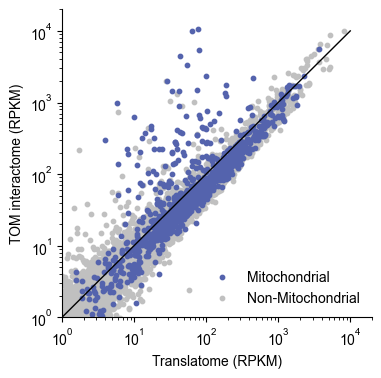

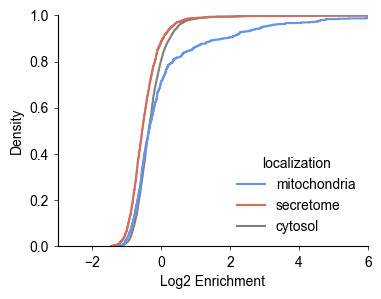

In [28]:
# Set plotting styles
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'

# === PART 1: Scatter plot of RPKM ===

# Load RPKM data
data = pd.read_csv(directory_path + 'gene_enrichment_list.csv')
x_value = f"{group1}_RPKM"
y_value = f"{group2}_RPKM"

# Create scatter plot
plt.figure(figsize=(4, 4))

# Plot non-mitochondrial genes
non_mito_mask = data['localization'] != 'mitochondria'
fig1 = plt.scatter(data.loc[non_mito_mask, x_value],
                   data.loc[non_mito_mask, y_value],
                   color='silver', edgecolor='silver', s=10, alpha=1)

# Plot mitochondrial genes
mito_mask = data['localization'] == 'mitochondria'
fig2 = plt.scatter(data.loc[mito_mask, x_value],
                   data.loc[mito_mask, y_value],
                   color='#5463ad', edgecolor='#5463ad', s=10, alpha=1)

# Style axes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=True, left=True)

# Labels and scales
plt.xlabel('Translatome (RPKM)', fontsize=10)
plt.ylabel('TOM interactome (RPKM)', fontsize=10)
plt.xscale('log')
plt.yscale('log')

# Diagonal reference line
plt.plot([1, 10000], [1, 10000], color='black', linewidth=1)

# Axis limits
plt.xlim(1, 20000)
plt.ylim(1, 20000)

# Legend
legend = ax.legend((fig2, fig1), ['Mitochondrial', 'Non-Mitochondrial'],
                   prop={'size': 10}, loc='lower right')
legend.get_frame().set_linewidth(0.0)

# Uncomment to save
# plt.savefig(publish_directory_path + 'TOM22_scatterplot_rm_ctrl.pdf', dpi=300, bbox_inches='tight')
plt.show()


# === PART 2: ECDF plot of log2 enrichment ===

# Load Log2 enrichment data
data = pd.read_csv(directory_path + 'gene_enrichment_list_threshold.csv')

# Define x-axis value
x_value = 'Log2_ratio'

# Plot ECDF
fig, ax = plt.subplots(figsize=(4, 3))
sns.ecdfplot(data=data,
             x=x_value,
             hue='localization',
             palette=['cornflowerblue', '#D66C5C', 'grey'],
             complementary=False)

# Style axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Density', fontsize=10)
ax.set_xlabel('Log2 Enrichment', fontsize=10)
ax.tick_params(bottom=True, left=True, width=0.5)
ax.tick_params(axis='both', labelsize=10, width=0.5, length=3)

# Legend
legend = ax.get_legend()
legend.get_frame().set_linewidth(0.0)

# Axis limits
ax.set_xlim(-3, 6)

# Uncomment to save
# plt.savefig(publish_directory_path + 'TOM22_CDF_all.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
def three_nt_periodicity(group):
    end = 150
    codon_positions = range(1, end + 1)
    read_counts = {i: 0 for i in codon_positions}
    position_counts = {i: 0 for i in codon_positions}

    total_genes = 0
    p = p1 if group == group1 else p2
    total_reads = p1_Total_Reads if group == group1 else p2_Total_Reads

    for gene, data in p.items():
        cds_length = int(data.attrs['cds_length'])
        norm_factor = sum(data[1]) / cds_length

        if norm_factor >= 0.5:
            total_genes += 1
            for pos in codon_positions:
                if pos in data[0]:
                    index = data[0].tolist().index(pos)
                    nt_reads = data[1][index]
                    norm_reads = nt_reads / norm_factor / 3

                    read_counts[pos] += norm_reads
                    position_counts[pos] += 1

    # Calculate normalized read counts
    normalized_reads = {
        pos: read_counts[pos] / position_counts[pos]
        for pos in codon_positions if position_counts[pos] > 0
    }

    # Convert to DataFrame and save
    three_nt_df = pd.DataFrame.from_dict(normalized_reads, orient='index', columns=['normalized_read_count'])
    three_nt_df.index.name = 'codon'
    three_nt_df.to_csv(f'{directory_path}/three_nt_{group}.csv')

    return three_nt_df



(0.0, 150.0)

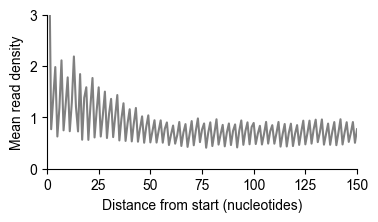

In [20]:
group = 'p1'
data = three_nt_periodicity(group)
x = data.index
y = data['normalized_read_count']

plt.figure(figsize=(4, 2))
plt.plot(x,y, color = 'grey')
plt.xlabel('Distance from start (nucleotides)')
plt.ylabel('Mean read density')

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom="on", left="on")

plt.ylim(0, 3)
plt.xlim(0, 150)


In [21]:
def heatmap_start_codon():
    min_RPC = 0.25
    scores_dict = {}
    data = pd.read_csv(directory_path + '/Mito_gene_enrichment_list.csv')
    data = data[(data['p1_norm'] >= min_RPC) | (data['p2_norm'] >= min_RPC)]
    data.to_csv(directory_path + '/Mito_gene_enrichment_list_threshold.csv', index=False)

    data = data[['Log2_ratio','SubMitoLocalization','gene', 'Length', 'UniProt', 'MTS?']].copy()
    data = data.drop_duplicates(subset='gene', keep='first')

    for gene in data['gene'].unique():
        cache_filename = f"{directory_path}/genes/{gene}.pkl"
        if os.path.exists(cache_filename):
            with open(cache_filename, 'rb') as f:
                y_data = pickle.load(f)
        else:
            os.makedirs(os.path.dirname(cache_filename), exist_ok=True)  # This line ensures the directory exists
            y_data = gene_enrichment(gene)
            if not y_data:  # Check if y3_data is empty or None, implying the gene does not exist
                print(f"Skipping {gene} as it does not exist.")
                data = data[data['gene'] != gene]
                continue  # Skip to the next iteration of the loop
            else:       
                with open(cache_filename, 'wb') as f:
                    pickle.dump(y_data, f)    
            
        y3_data = y_data[3]
        scores_dict[gene] = {i: np.log2(score) for i, score in enumerate(y3_data)}
    # Convert the scores dictionary into a DataFrame
    score_data = pd.DataFrame(scores_dict).transpose()

    # Concatenate the original data and the score data
    data.set_index('gene', inplace=True)
    data = pd.concat([data, score_data], axis=1)

    return data


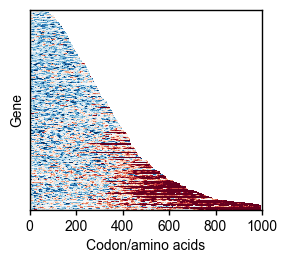

In [22]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'

# === 1. Load and preprocess the heatmap data ===

# Generate codon-level heatmap data
heatmap_df_mito = heatmap_start_codon()

# Limit to first 1000 codons, reset index
df = heatmap_df_mito.iloc[:, :1000].copy()
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'gene'})

# Filter for MTS-positive genes
df = df[df['MTS?'] == 'yes']

# Sort by gene length and clean columns
df = df.sort_values(by='Length')
df = df.set_index('gene')
df = df.drop(columns=['SubMitoLocalization', 'Length', 'UniProt', 'MTS?'])

# === 2. Configure heatmap parameters ===

# Create a mask for NaN values
nan_mask = np.isnan(df)

# Custom colormap (white for NaNs)
cmap = plt.get_cmap('RdBu_r')
cmap.set_bad("white")

# === 3. Plot the heatmap ===

fig, ax = plt.subplots(figsize=(3, 2.6))

sns.heatmap(
    df,
    vmin=-2.5, vmax=2.5,
    yticklabels=False,
    cmap=cmap,
    mask=nan_mask,
    cbar=False,
    ax=ax,
    cbar_kws={"shrink": 0.15, "aspect": 4}
)

# Style spines
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)

# Style ticks
tick_positions = np.arange(0, 1000 + 1, 200)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_positions, rotation=0, color='black', size=10)
ax.tick_params(width=1)

# Axis labels
ax.set_xlabel('Codon/amino acids', fontsize=10, color='black')
ax.set_ylabel('Gene', fontsize=10, color='black')

# === 4. Save or show ===
# plt.savefig(publish_directory_path + 'heatmap_mito_MTS.pdf', dpi=600, bbox_inches='tight')
plt.show()


In [23]:
# Helper function to get the path where results for a gene are saved
def get_nt_to_codon_path(gene, p_type, directory_path):
    filename = f"{gene}_{p_type}.pkl"
    return os.path.join(directory_path, "genes", filename)  # Added "genes" subdirectory

def cached_nt_to_codon(p_type, gene, directory_path):
    file_path = get_nt_to_codon_path(gene, p_type, directory_path)
    
    if os.path.exists(file_path):
        with open(file_path, "rb") as file:
            return pickle.load(file)
    
    # Ensure the directory exists before attempting to write
    os.makedirs(os.path.dirname(file_path), exist_ok=True)  # This line ensures the directory exists
    
    result = nt_to_codon(p_type, gene)
    with open(file_path, "wb") as file:
        pickle.dump(result, file)
    
    return result

def initialize_dict(codons, keys=None):
    if not keys:
        return {i: [] for i in codons}
    else:
        return {key: [] for key in keys}

def calculate_mean_and_CI(codon_dict, full_dict, mean_key, upper_key, lower_key, confidence_interval, codons):
    for i in codons:
        resampled_means = [np.nanmean(resample(codon_dict[i], n_samples=len(codon_dict[i]))) for _ in range(100)]
        full_dict[mean_key].append(np.nanmean(codon_dict[i]))
        
        lower_quantile = np.quantile(resampled_means, 0.5 * (1 - confidence_interval))
        upper_quantile = np.quantile(resampled_means, 1 - 0.5 * (1 - confidence_interval))
        
        full_dict[upper_key].append(lower_quantile)
        full_dict[lower_key].append(upper_quantile)

def metagene_start_codon(localization, end, directory_path):
    codons = list(range(1, end + 1))
    codon_dict1 = initialize_dict(codons)
    codon_dict2 = initialize_dict(codons)
    min_RPC = 0.25

    df = pd.read_csv(f'{directory_path}gene_enrichment_list.csv')
    df = df[df['localization'] == localization]
    df = df[(df['p1_norm'] >= min_RPC) | (df['p2_norm'] >= min_RPC)]
    # df = df[(df['p1_norm'] >= min_RPC) | (df['p2_norm'] >= min_RPC)]
    # df = df[df['Length'] >= 300]

    num = 0
    for _, row in df.iterrows():
        gene = row.iloc[0]
        codon_length = row['Length']
        p1_norm = row['p1_norm']
        p2_norm = row['p2_norm']
    
        Dict1 = cached_nt_to_codon('p1', gene, directory_path)
        Dict2 = cached_nt_to_codon('p2', gene, directory_path)
        
        num += 1
        
        for k in range(1, min(codon_length, end) + 1):
            codon_dict1[k].append(Dict1.get(k, 0.01) / p1_norm)
            codon_dict2[k].append(Dict2.get(k, 0.01) / p2_norm)

    confidence_interval = 0.95
    keys = ['mean1', 'CI_upper1', 'CI_lower1', 'mean2', 'CI_upper2', 'CI_lower2']
    full_dict = initialize_dict(keys)

    calculate_mean_and_CI(codon_dict1, full_dict, 'mean1', 'CI_upper1', 'CI_lower1', confidence_interval, codons)
    calculate_mean_and_CI(codon_dict2, full_dict, 'mean2', 'CI_upper2', 'CI_lower2', confidence_interval, codons)


    metagene_df = pd.DataFrame(full_dict)
    metagene_df.to_csv(f'{directory_path}{localization}_metagene_start_codon.csv', index=None)
    print(num)
    return full_dict

In [24]:
end = 600
localization = 'mitochondria'

meta_Dict = metagene_start_codon(localization, end, directory_path)


752


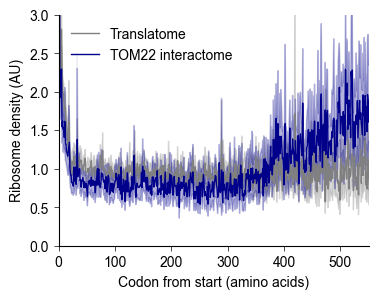

In [25]:
# Load precomputed CSV
data = pd.read_csv(f'{directory_path}/{localization}_metagene_start_codon.csv')
x = range(1, end + 1)

# === Plotting ===
color1 = 'grey'
color2 = 'darkblue'

plt.figure(figsize=(4, 3))

# Plot mean curves
plt.plot(x, data['mean1'], color=color1, linewidth=1)
plt.plot(x, data['mean2'], color=color2, linewidth=1)

# Plot confidence intervals
plt.fill_between(x, data['CI_upper1'], data['CI_lower1'], color=color1, alpha=0.3)
plt.fill_between(x, data['CI_upper2'], data['CI_lower2'], color=color2, alpha=0.3)

# Axes limits and labels
plt.xlim(0, 550)
plt.ylim(0, 3)
plt.xlabel('Codon from start (amino acids)', fontsize=10)
plt.ylabel('Ribosome density (AU)', fontsize=10)

# Legend
legend = plt.legend(['Translatome', 'TOM22 interactome'], loc='upper left')
legend.get_frame().set_linewidth(0.0)

# Clean up spines and ticks
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=True, left=True, width=0.5)

# Save or show
# plt.savefig(publish_directory_path + 'metagene_start_mitochondria.pdf', dpi=300, bbox_inches='tight')
plt.show()
